<a href="https://colab.research.google.com/github/mashihan123/ViT-Truck-Images/blob/main/Truck_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip -q install vit_pytorch linformer

In [73]:
!unzip -uq "bbb.zip"

In [108]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import shutil, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

print(f"Torch: {torch.__version__}")

Torch: 1.7.0+cu101


In [109]:
# Training settings
batch_size = 64
epochs = 50
lr = 3e-5
gamma = 0.7
seed = 42

In [110]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

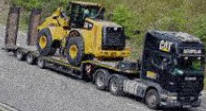

In [121]:
# example of cropping an image
path = 'bbb'
file = '10129-AUG-1.jpg'
im = Image.open(os.path.join(path,file))
with open('bbb/10129-AUG-1.txt','r') as f:
  text = f.read()
  x = float(text.split()[1])*im.size[0]
  y = float(text.split()[2])*im.size[1]
  w = float(text.split()[3])*im.size[0]
  h = float(text.split()[4])*im.size[1]
cropped_image = im.crop((x-w/2, y-h/2, x+w/2, y+h/2))

cropped_image


In [72]:
# rm -rf bbb

In [79]:
# cropping all images and store in cropped folder
if not os.path.exists('cropped'): os.mkdir('cropped') 
path = 'bbb'
files = os.listdir(path)
for index, file in enumerate(files):
    if file.endswith('.jpg'):
      im = Image.open(os.path.join(path,file))
      with open(os.path.join(path, ''.join([file.split(".")[0],'.txt'])), 'r') as f:
        text = f.read()
        x = float(text.split()[1])*im.size[0]
        y = float(text.split()[2])*im.size[1]
        w = float(text.split()[3])*im.size[0]
        h = float(text.split()[4])*im.size[1]
      cropped_image = im.crop((x-w/2, y-h/2, x+w/2, y+h/2))
      cropped_image.save(os.path.join('cropped', ''.join([file.split(".")[0],'.jpg'])))  
      shutil.copy(os.path.join(path, ''.join([file.split(".")[0],'.txt'])), 'cropped')

In [122]:
device = 'cuda'
os.makedirs('data', exist_ok=True)
data_dir = 'bbb'
cropped_dir = 'cropped'
# data_dir = 'cropped'
# train_dir = 'data/train'
# test_dir = 'data/test'
# with zipfile.ZipFile('train.zip') as train_zip:
#     train_zip.extractall('data')  
# with zipfile.ZipFile('test.zip') as test_zip:
#     test_zip.extractall('data')
train_list = glob.glob(os.path.join(data_dir,'*.jpg'))

labels=[]

for root in train_list:
  path = os.path.dirname(root)
  name = root.split("/")[-1].split(".")[0]
  with open(os.path.join(path, ''.join([name,'.txt'])), 'r') as f:
    text = f.read()
    label = int(text.split()[0])+1
    labels.append(label)


train_list, test_list = train_test_split(train_list, 
                        test_size=0.33,
                        stratify=labels,
                       random_state=seed)
# train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
# test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
print(labels)
print(train_list)

Train Data: 2847
Test Data: 1403
[10, 2, 2, 5, 9, 9, 2, 2, 5, 9, 9, 2, 2, 9, 10, 10, 6, 6, 1, 2, 9, 11, 2, 5, 9, 2, 13, 8, 13, 2, 2, 2, 2, 9, 2, 2, 1, 9, 5, 1, 2, 7, 2, 9, 9, 5, 9, 9, 2, 9, 9, 5, 2, 10, 9, 9, 9, 2, 9, 9, 9, 4, 2, 9, 9, 10, 9, 9, 2, 9, 7, 2, 9, 2, 9, 9, 9, 7, 9, 9, 13, 7, 4, 9, 2, 2, 13, 9, 8, 3, 2, 9, 9, 7, 4, 2, 1, 9, 9, 9, 9, 9, 3, 2, 2, 9, 2, 2, 6, 9, 9, 13, 1, 1, 5, 1, 6, 10, 9, 1, 9, 2, 9, 2, 11, 9, 9, 9, 9, 9, 9, 9, 2, 4, 2, 2, 6, 9, 2, 6, 6, 7, 2, 9, 9, 13, 8, 9, 9, 9, 9, 9, 9, 9, 5, 2, 11, 6, 2, 9, 6, 9, 9, 6, 2, 3, 9, 3, 3, 2, 2, 9, 9, 9, 9, 7, 2, 1, 9, 7, 9, 12, 9, 9, 3, 11, 9, 6, 9, 9, 2, 5, 9, 7, 9, 4, 2, 7, 9, 9, 9, 9, 5, 4, 9, 9, 9, 9, 9, 9, 9, 2, 7, 4, 2, 1, 3, 9, 13, 13, 2, 9, 11, 9, 2, 3, 9, 9, 2, 9, 2, 1, 1, 11, 7, 10, 5, 2, 2, 9, 9, 9, 9, 2, 9, 6, 13, 7, 9, 2, 7, 2, 9, 12, 8, 2, 9, 2, 9, 9, 6, 2, 9, 9, 9, 9, 7, 9, 9, 9, 9, 2, 2, 13, 2, 7, 9, 9, 9, 9, 13, 7, 2, 1, 2, 9, 9, 9, 2, 9, 4, 1, 6, 13, 9, 2, 2, 13, 9, 9, 9, 9, 13, 4, 4, 9, 5, 6, 9, 7, 6, 9, 9

In [ ]:
labels = []
for root in train_list:
  path = os.path.dirname(root)
  name = root.split("/")[-1].split(".")[0]
  with open(os.path.join(path, ''.join([name,'.txt'])), 'r') as f:
    text = f.read()
    label = int(text.split()[0])+1
    labels.append(label)

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [124]:
# split dataset
train_list, valid_list = train_test_split(train_list, 
                        test_size=0.2,
                        stratify=labels,
                       random_state=seed)


In [125]:

print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 2277
Validation Data: 570
Test Data: 1403


In [126]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [127]:
class trucksDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        name = img_path.split("/")[-1].split(".")[0]
        path = os.path.dirname(img_path)
        with open(os.path.join(path, ''.join([name,'.txt'])), 'r') as f:
          text = f.read()
          label = int(text.split()[0])
        # label = img_path.split("/")[-1].split(".")[0]
        # label = 1 if label == "dog" else 0

        return img_transformed, label

In [128]:
train_data = trucksDataset(train_list, transform=train_transforms)
valid_data = trucksDataset(valid_list, transform=test_transforms)
test_data = trucksDataset(test_list, transform=test_transforms)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

2277 36
570 9


In [129]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=13,
    transformer=efficient_transformer,
    channels=3,
).to(device)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [130]:
epoch50 = []
accuracy_train = []
accuracy_test = []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    epoch50.append(epoch)
    accuracy_train.append(epoch_accuracy)
    accuracy_test.append(epoch_val_accuracy)
epoch50 = [x+1 for x in epoch50]


Epoch : 1 - loss : 2.1180 - acc: 0.3388 - val_loss : 2.0045 - val_acc: 0.3809




Epoch : 2 - loss : 2.0033 - acc: 0.3803 - val_loss : 1.9871 - val_acc: 0.3800




Epoch : 3 - loss : 1.9848 - acc: 0.3810 - val_loss : 1.9797 - val_acc: 0.3796




Epoch : 4 - loss : 1.9725 - acc: 0.3816 - val_loss : 1.9505 - val_acc: 0.3796




Epoch : 5 - loss : 1.9275 - acc: 0.3819 - val_loss : 1.8837 - val_acc: 0.3801




Epoch : 6 - loss : 1.8283 - acc: 0.3901 - val_loss : 1.7480 - val_acc: 0.4151




Epoch : 7 - loss : 1.7079 - acc: 0.4425 - val_loss : 1.6616 - val_acc: 0.4720




Epoch : 8 - loss : 1.6609 - acc: 0.4525 - val_loss : 1.6278 - val_acc: 0.4616




Epoch : 9 - loss : 1.6178 - acc: 0.4805 - val_loss : 1.5670 - val_acc: 0.4825




Epoch : 10 - loss : 1.5934 - acc: 0.4876 - val_loss : 1.5504 - val_acc: 0.4996




Epoch : 11 - loss : 1.5504 - acc: 0.4959 - val_loss : 1.5185 - val_acc: 0.5201




Epoch : 12 - loss : 1.5092 - acc: 0.5128 - val_loss : 1.5024 - val_acc: 0.5189




Epoch : 13 - loss : 1.4489 - acc: 0.5441 - val_loss : 1.4466 - val_acc: 0.5374




Epoch : 14 - loss : 1.4165 - acc: 0.5556 - val_loss : 1.4210 - val_acc: 0.5356




Epoch : 15 - loss : 1.4089 - acc: 0.5501 - val_loss : 1.3555 - val_acc: 0.5667




Epoch : 16 - loss : 1.3409 - acc: 0.5687 - val_loss : 1.3447 - val_acc: 0.5545




Epoch : 17 - loss : 1.3278 - acc: 0.5804 - val_loss : 1.3594 - val_acc: 0.5571




Epoch : 18 - loss : 1.3428 - acc: 0.5813 - val_loss : 1.3391 - val_acc: 0.5509




Epoch : 19 - loss : 1.3314 - acc: 0.5815 - val_loss : 1.3353 - val_acc: 0.5551




Epoch : 20 - loss : 1.2880 - acc: 0.5854 - val_loss : 1.3101 - val_acc: 0.5811




Epoch : 21 - loss : 1.2907 - acc: 0.5829 - val_loss : 1.3003 - val_acc: 0.5634




Epoch : 22 - loss : 1.2802 - acc: 0.5855 - val_loss : 1.3114 - val_acc: 0.5793




Epoch : 23 - loss : 1.2663 - acc: 0.5990 - val_loss : 1.2887 - val_acc: 0.5863




Epoch : 24 - loss : 1.2566 - acc: 0.6014 - val_loss : 1.2175 - val_acc: 0.5849




Epoch : 25 - loss : 1.2756 - acc: 0.5970 - val_loss : 1.2898 - val_acc: 0.5698




Epoch : 26 - loss : 1.2304 - acc: 0.6105 - val_loss : 1.2581 - val_acc: 0.5773




Epoch : 27 - loss : 1.2175 - acc: 0.6172 - val_loss : 1.2687 - val_acc: 0.5781




Epoch : 28 - loss : 1.2104 - acc: 0.6202 - val_loss : 1.2283 - val_acc: 0.6060




Epoch : 29 - loss : 1.2139 - acc: 0.6188 - val_loss : 1.2382 - val_acc: 0.5986




Epoch : 30 - loss : 1.1900 - acc: 0.6177 - val_loss : 1.2022 - val_acc: 0.6075




Epoch : 31 - loss : 1.1961 - acc: 0.6163 - val_loss : 1.2263 - val_acc: 0.6153




Epoch : 32 - loss : 1.1963 - acc: 0.6247 - val_loss : 1.2285 - val_acc: 0.5969




Epoch : 33 - loss : 1.1937 - acc: 0.6162 - val_loss : 1.1923 - val_acc: 0.6115




Epoch : 34 - loss : 1.1965 - acc: 0.6122 - val_loss : 1.2053 - val_acc: 0.6084




Epoch : 35 - loss : 1.1972 - acc: 0.6178 - val_loss : 1.1783 - val_acc: 0.6273




Epoch : 36 - loss : 1.1932 - acc: 0.6154 - val_loss : 1.1613 - val_acc: 0.6163




Epoch : 37 - loss : 1.1564 - acc: 0.6319 - val_loss : 1.1816 - val_acc: 0.6093




Epoch : 38 - loss : 1.1670 - acc: 0.6289 - val_loss : 1.1877 - val_acc: 0.6031




Epoch : 39 - loss : 1.1648 - acc: 0.6230 - val_loss : 1.1732 - val_acc: 0.6263




Epoch : 40 - loss : 1.1587 - acc: 0.6244 - val_loss : 1.2143 - val_acc: 0.6149




Epoch : 41 - loss : 1.1640 - acc: 0.6244 - val_loss : 1.1543 - val_acc: 0.6266




Epoch : 42 - loss : 1.1606 - acc: 0.6236 - val_loss : 1.1495 - val_acc: 0.6143




Epoch : 43 - loss : 1.1561 - acc: 0.6245 - val_loss : 1.1535 - val_acc: 0.6337




Epoch : 44 - loss : 1.1551 - acc: 0.6249 - val_loss : 1.1717 - val_acc: 0.6245




Epoch : 45 - loss : 1.1581 - acc: 0.6303 - val_loss : 1.1709 - val_acc: 0.6284




Epoch : 46 - loss : 1.1311 - acc: 0.6380 - val_loss : 1.2048 - val_acc: 0.6031




Epoch : 47 - loss : 1.1486 - acc: 0.6219 - val_loss : 1.1380 - val_acc: 0.6289




Epoch : 48 - loss : 1.1246 - acc: 0.6289 - val_loss : 1.1734 - val_acc: 0.6103




Epoch : 49 - loss : 1.1522 - acc: 0.6280 - val_loss : 1.1635 - val_acc: 0.6097




Epoch : 50 - loss : 1.1358 - acc: 0.6307 - val_loss : 1.1380 - val_acc: 0.6308



Text(0.5, 1.0, 'Model Accuracy')

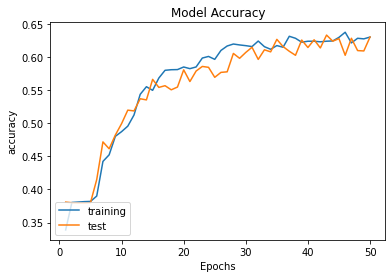

In [131]:


plt.plot(epoch50, accuracy_train,label='training')
plt.plot(epoch50, accuracy_test,label='test')
plt.legend(loc='lower left')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Model Accuracy')


